# Result visualization
This notebook loads final checkpoints and generates plots in the same directory where it is located.

The following plots are created:
- Evolution of the test and validation set accuracy
- Evolution of the difference between validation and test set accuracies
- Evolution of the membrane time constant parameters in each PLIF neuron layer

The results feature four models:
1. **baseline**: the replicated baseline model from the original work on the PLIF neurons. This work uses the model initialized using $\tau_{0}=2$.
2. **tau_per_neuron**: this corresponds to the "No regularization" model. 
3. **tau_per_neuron_regularization1**: This corresponds to the "$\lambda=0.01$" model.
4. **tau_per_neuron_regularization2**: This corresponds to the "$\lambda=0.1$" model.

Models 2., 3., and 4. are initialized using a log-normal distribution with $\mu=2$ and $\sigma=0.1$.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import spikingjelly

In [2]:
baseline_dir = '../checkpoints/pt_BASELINE_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.0/checkpoint.pt'
tau_per_neuron_dir = '../checkpoints/pt_NO_REG_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.1/checkpoint.pt'
tau_per_neuron_regularization1_dir = '../checkpoints/pt_REGULARIZATION_.01_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.1/checkpoint.pt'
tau_per_neuron_regularization2_dir = '../checkpoints/pt_REGULARIZATION_.1_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.1/checkpoint.pt'

### Initialize network models

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
from spikingjelly.clock_driven import layer, surrogate
from spikingjelly.clock_driven.neuron import BaseNode, LIFNode

# 1.
class PLIFNodeBaseline(BaseNode):
    def __init__(self, out_shape, init_tau=2.0, tau_std_dev=0, v_threshold=1.0, v_reset=0.0, detach_reset=True, surrogate_function=surrogate.ATan(), monitor_state=False):
        super().__init__(v_threshold, v_reset, surrogate_function, detach_reset, monitor_state)
        init_w = 0.0 # Tau 2.0
        self.w = nn.Parameter(torch.tensor(init_w, dtype=torch.float))

    def forward(self, dv: torch.Tensor):
        if self.v_reset is None:
            self.v += (dv - self.v) * self.w.sigmoid()
        else:
            self.v += (dv - (self.v - self.v_reset)) * self.w.sigmoid()
        return self.spiking()

    def tau(self):
        return 1 / self.w.data.sigmoid().item()

    def extra_repr(self):
        return f'v_threshold={self.v_threshold}, v_reset={self.v_reset}, tau={self.tau()}'
    
class PLIFNodeIndividualTaus(BaseNode):
    def __init__(self, out_shape, init_tau=2.0, tau_std_dev=0, v_threshold=1.0, v_reset=0.0, detach_reset=True, surrogate_function=surrogate.ATan(), monitor_state=False):
        super().__init__(v_threshold, v_reset, surrogate_function, detach_reset, monitor_state)
        init_w = torch.full(out_shape, 0.0) # In the experiments, log_normal initialization is used.
        self.w = nn.Parameter(torch.tensor(init_w, dtype=torch.float))

    def forward(self, dv: torch.Tensor):
        if self.v_reset is None:
            self.v += (dv - self.v) * self.w.sigmoid()
        else:
            self.v += (dv - (self.v - self.v_reset)) * self.w.sigmoid()
        return self.spiking()

    def tau(self):
        return 1 / self.w.data.sigmoid()

    def extra_repr(self):
        return f'v_threshold={self.v_threshold}, v_reset={self.v_reset}, tau={self.tau()}'
    
def create_conv_sequential_individual_taus(in_channels, out_channels, number_layer, init_tau, tau_std_dev, use_plif, use_max_pool, alpha_learnable, detach_reset):
    conv = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        PLIFNodeIndividualTaus(out_shape=torch.Size([1, 128, 128, 128]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
        nn.MaxPool2d(2, 2) if use_max_pool else nn.AvgPool2d(2, 2)
    ]

    for i in range(number_layer - 1):
        conv.extend([
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            PLIFNodeIndividualTaus(out_shape=torch.Size([1, 128, 64 // (2 ** i), 64 // (2 ** i)]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
            nn.MaxPool2d(2, 2) if use_max_pool else nn.AvgPool2d(2, 2)
        ])
    return nn.Sequential(*conv)


def create_2fc_individual_taus(channels, h, w, dpp, class_num, init_tau, tau_std_dev, use_plif, alpha_learnable, detach_reset):
    return nn.Sequential(
        nn.Flatten(),
        layer.Dropout(dpp),
        nn.Linear(channels * h * w, channels * h * w // 4, bias=False),
        PLIFNodeIndividualTaus(out_shape=torch.Size([1, 512]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
        layer.Dropout(dpp, dropout_spikes=True),
        nn.Linear(channels * h * w // 4, class_num * 10, bias=False),
        PLIFNodeIndividualTaus(out_shape=torch.Size([1, class_num * 10]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
    )

def create_conv_sequential(in_channels, out_channels, number_layer, init_tau, tau_std_dev, use_plif, use_max_pool, alpha_learnable, detach_reset):
    conv = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        PLIFNodeBaseline(out_shape=torch.Size([1, 128, 128, 128]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
        nn.MaxPool2d(2, 2) if use_max_pool else nn.AvgPool2d(2, 2)
    ]

    for i in range(number_layer - 1):
        conv.extend([
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            PLIFNodeBaseline(out_shape=torch.Size([1, 128, 64 // (2 ** i), 64 // (2 ** i)]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
            nn.MaxPool2d(2, 2) if use_max_pool else nn.AvgPool2d(2, 2)
        ])
    return nn.Sequential(*conv)


def create_2fc(channels, h, w, dpp, class_num, init_tau, tau_std_dev, use_plif, alpha_learnable, detach_reset):
    return nn.Sequential(
        nn.Flatten(),
        layer.Dropout(dpp),
        nn.Linear(channels * h * w, channels * h * w // 4, bias=False),
        PLIFNodeBaseline(out_shape=torch.Size([1, 512]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
        layer.Dropout(dpp, dropout_spikes=True),
        nn.Linear(channels * h * w // 4, class_num * 10, bias=False),
        PLIFNodeBaseline(out_shape=torch.Size([1, class_num * 10]), init_tau=init_tau, tau_std_dev=tau_std_dev, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset) if use_plif else LIFNode(tau=init_tau, surrogate_function=surrogate.ATan(learnable=alpha_learnable), detach_reset=detach_reset),
    )


class NeuromorphicNet(nn.Module):
    def __init__(self, T, init_tau, tau_std_dev, use_plif, use_max_pool, alpha_learnable, detach_reset):
        super().__init__()
        self.T = T
        self.init_tau = init_tau
        self.tau_std_dev = tau_std_dev
        self.use_plif = use_plif
        self.use_max_pool = use_max_pool
        self.alpha_learnable = alpha_learnable
        self.detach_reset = detach_reset

        self.train_times = 0
        self.max_test_accuracy = 0
        self.epoch = 0
        self.conv = None
        self.fc = None
        self.boost = nn.AvgPool1d(10, 10)

    def forward(self, x):
        x = x.permute(1, 0, 2, 3, 4)  # [T, N, 2, *, *]
        out_spikes_counter = self.boost(self.fc(self.conv(x[0])).unsqueeze(1)).squeeze(1)
        for t in range(1, x.shape[0]):
            out_spikes_counter += self.boost(self.fc(self.conv(x[t])).unsqueeze(1)).squeeze(1)
        return out_spikes_counter


class DVS128GestureNetIndividualTaus(NeuromorphicNet):
    def __init__(self, T, init_tau, tau_std_dev, use_plif, use_max_pool, alpha_learnable, detach_reset, channels, number_layer):
        super().__init__(T=T, init_tau=init_tau, tau_std_dev=tau_std_dev, use_plif=use_plif, use_max_pool=use_max_pool, alpha_learnable=alpha_learnable, detach_reset=detach_reset)
        w = 128
        h = 128
        self.conv = create_conv_sequential_individual_taus(2, channels, number_layer=number_layer, init_tau=init_tau, tau_std_dev=tau_std_dev, use_plif=use_plif,
                                           use_max_pool=use_max_pool, alpha_learnable=alpha_learnable, detach_reset=detach_reset)
        self.fc = create_2fc_individual_taus(channels=channels, w=w >> number_layer, h=h >> number_layer, dpp=0.5, class_num=11,
                             init_tau=init_tau, tau_std_dev=tau_std_dev, use_plif=use_plif, alpha_learnable=alpha_learnable, detach_reset=detach_reset)
        
class DVS128GestureNetBaseline(NeuromorphicNet):
    def __init__(self, T, init_tau, tau_std_dev, use_plif, use_max_pool, alpha_learnable, detach_reset, channels, number_layer):
        super().__init__(T=T, init_tau=init_tau, tau_std_dev=tau_std_dev, use_plif=use_plif, use_max_pool=use_max_pool, alpha_learnable=alpha_learnable, detach_reset=detach_reset)
        w = 128
        h = 128
        self.conv = create_conv_sequential(2, channels, number_layer=number_layer, init_tau=init_tau, tau_std_dev=tau_std_dev, use_plif=use_plif,
                                           use_max_pool=use_max_pool, alpha_learnable=alpha_learnable, detach_reset=detach_reset)
        self.fc = create_2fc(channels=channels, w=w >> number_layer, h=h >> number_layer, dpp=0.5, class_num=11,
                             init_tau=init_tau, tau_std_dev=tau_std_dev, use_plif=use_plif, alpha_learnable=alpha_learnable, detach_reset=detach_reset)


In [4]:
def get_log_dictionary(log):
    data = {}
    for epoch in log:
        for entry in epoch:
            if entry[0] not in data:
                data[entry[0]] = []
            data[entry[0]].append(entry[1])
    return data

### Extract logs

In [5]:
# Mock the models module
import sys
import types

models = types.ModuleType('models')
models.DVS128GestureNet = DVS128GestureNetBaseline
models.PLIFNode = PLIFNodeBaseline
sys.modules['models'] = models

# 1.
baseline_pt = torch.load(baseline_dir, map_location='cpu')
baseline_net = baseline_pt['net']
baseline_log = get_log_dictionary(baseline_pt['log_data_list'])

models = types.ModuleType('models')
models.DVS128GestureNet = DVS128GestureNetIndividualTaus
models.PLIFNode = PLIFNodeIndividualTaus
sys.modules['models'] = models

def get_tau_weights(net):
    weights_mean_std = []
    weights_final_distribution = []
    for id, m in enumerate(net.modules()):
        if isinstance(m, models.PLIFNode):
            weights_mean_std.append({
                'mean': torch.mean(1.0/m.w.sigmoid()).item(),
                'std': torch.std(1.0/m.w.sigmoid()).item()
            })
            weights_final_distribution.append((1.0/m.w.sigmoid()).data)
    return weights_mean_std, weights_final_distribution

# 3.
tau_per_neuron_pt = torch.load(tau_per_neuron_dir, map_location='cpu')
tau_per_neuron_net = tau_per_neuron_pt['net']
tau_per_neuron_log = get_log_dictionary(tau_per_neuron_pt['log_data_list'])
tau_per_neuron_weights_final, tau_per_neuron_weights_final_dist = get_tau_weights(tau_per_neuron_net)

# 4.
tau_per_neuron_regularization1_pt = torch.load(tau_per_neuron_regularization1_dir, map_location='cpu')
tau_per_neuron_regularization1_net = tau_per_neuron_regularization1_pt['net']
tau_per_neuron_regularization1_log = get_log_dictionary(tau_per_neuron_regularization1_pt['log_data_list'])
tau_per_neuron_regularization1_weights_final, tau_per_neuron_regularization1_weights_final_dist = get_tau_weights(tau_per_neuron_regularization1_net)

# 5.
tau_per_neuron_regularization2_pt = torch.load(tau_per_neuron_regularization2_dir, map_location='cpu')
tau_per_neuron_regularization2_net = tau_per_neuron_regularization2_pt['net']
tau_per_neuron_regularization2_log = get_log_dictionary(tau_per_neuron_regularization2_pt['log_data_list'])
tau_per_neuron_regularization2_weights_final, tau_per_neuron_regularization2_weights_final_dist = get_tau_weights(tau_per_neuron_regularization2_net)

### Evolution of test and validation accuracy

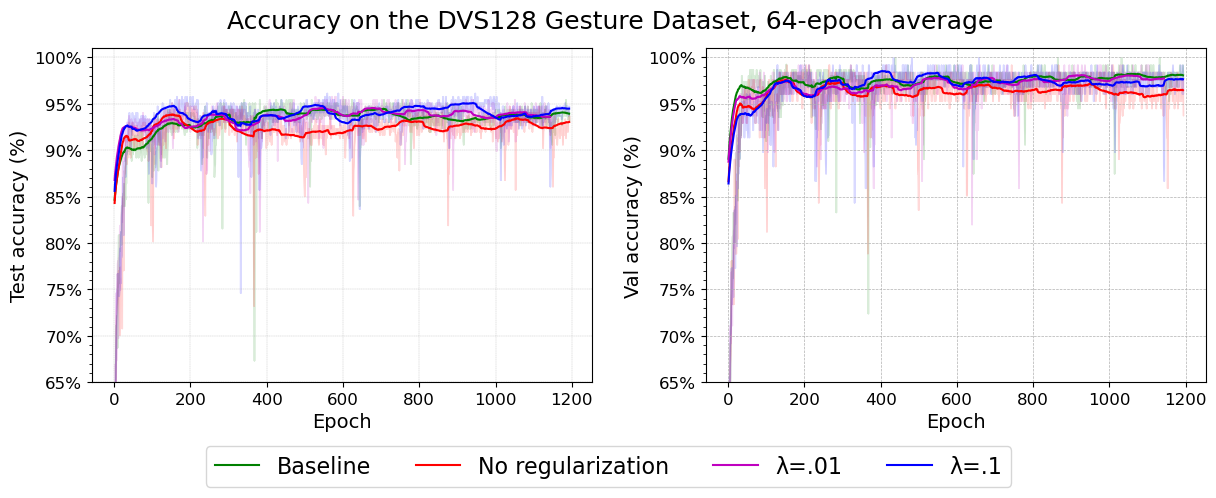

In [6]:
def moving_average(values, window):
    return np.convolve(values, np.ones(window)/window, mode='valid')

def moving_range(values, window):
    min_vals = np.array([np.min(values[i:i+window]) for i in range(len(values) - window + 1)])
    max_vals = np.array([np.max(values[i:i+window]) for i in range(len(values) - window + 1)])
    return min_vals, max_vals

baseline_test_acc = baseline_log['test_accuracy'][:1256]
tau_per_neuron_test_acc = tau_per_neuron_log['test_accuracy'][:1256]
tau_per_neuron_regularization1_test_acc = tau_per_neuron_regularization1_log['test_accuracy'][:1256]
tau_per_neuron_regularization2_test_acc = tau_per_neuron_regularization2_log['test_accuracy'][:1256]

test_labels = ['Baseline', 'No regularization', 'λ=.01', 'λ=.1']
test_accuracy_values = [baseline_test_acc, tau_per_neuron_test_acc, tau_per_neuron_regularization1_test_acc, tau_per_neuron_regularization2_test_acc]
colors = ['g', 'r', 'm', 'b']
window_size = 64
fill_alpha = 0.15

baseline_val_acc = baseline_log['val_accuracy'][:1256]
tau_per_neuron_val_acc = tau_per_neuron_log['val_accuracy'][:1256]
tau_per_neuron_regularization1_val_acc = tau_per_neuron_regularization1_log['val_accuracy'][:1256]
tau_per_neuron_regularization2_val_acc = tau_per_neuron_regularization2_log['val_accuracy'][:1256]

val_labels = ['Baseline', 'No regularization', 'λ=.01', 'λ=.1']
val_accuracy_values = [baseline_val_acc, tau_per_neuron_val_acc, tau_per_neuron_regularization1_val_acc, tau_per_neuron_regularization2_val_acc]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i in range(len(test_labels)):
    acc_values = test_accuracy_values[i]
    ma_values = moving_average(acc_values, window_size)
    min_vals, max_vals = moving_range(acc_values, window_size)
    
    epochs = np.arange(1, 1 + len(ma_values))
    
    axs[0].plot(epochs, ma_values, color=colors[i], label=f'{test_labels[i]}', linewidth=1.5)
    # axs[0].fill_between(epochs, min_vals, max_vals, color=colors[i], alpha=0.1)
    axs[0].fill_between(epochs, [acc_values[i] for i in range(len(acc_values)-window_size+1)], [acc_values[i+1] for i in range(len(acc_values)-window_size+1)], color=colors[i], alpha=fill_alpha)

axs[0].set_xlabel('Epoch', fontsize=14)
axs[0].set_ylabel('Test accuracy (%)', fontsize=14)
axs[0].set_ylim(0.65, 1.01)
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
yticks_major = np.arange(0.65, 1.01, 0.05)
yticks_minor = np.arange(0.65, 1.01, 0.01)
axs[0].set_yticks(yticks_major)
axs[0].set_yticks(yticks_minor, minor=True)
axs[0].set_yticklabels([f'{int(round(y * 100))}%' for y in yticks_major], fontsize=12)
axs[0].grid(True, linestyle='--', linewidth=0.25)

for i in range(len(val_labels)):
    acc_values = val_accuracy_values[i]
    ma_values = moving_average(acc_values, window_size)
    min_vals, max_vals = moving_range(acc_values, window_size)
    
    epochs = np.arange(1, 1 + len(ma_values))
    
    axs[1].plot(epochs, ma_values, color=colors[i], label=f'{val_labels[i]}', linewidth=1.5)
    # axs[1].fill_between(epochs, min_vals, max_vals, color=colors[i], alpha=0.1)
    axs[1].fill_between(epochs, [acc_values[i] for i in range(len(acc_values)-window_size+1)], [acc_values[i+1] for i in range(len(acc_values)-window_size+1)], color=colors[i], alpha=fill_alpha)

axs[1].set_xlabel('Epoch', fontsize=14)
axs[1].set_ylabel('Val accuracy (%)', fontsize=14)
axs[1].set_ylim(0.65, 1.01)
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
yticks_major = np.arange(0.65, 1.01, 0.05)
yticks_minor = np.arange(0.65, 1.01, 0.01)
axs[1].set_yticks(yticks_major)
axs[1].set_yticks(yticks_minor, minor=True)
axs[1].set_yticklabels([f'{int(round(y * 100))}%' for y in yticks_major], fontsize=12)
axs[1].grid(True, linestyle='--', linewidth=0.5)

fig.suptitle(f'Accuracy on the DVS128 Gesture Dataset, {window_size}-epoch average', fontsize=18)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=16)

plt.tight_layout(rect=[0, 0.135, 1, 0.95], pad=0.0, w_pad=2.0)
plt.savefig('combined_accuracy.png', dpi=250)
plt.show()

### Evolution of the difference between validation and test set accuracy

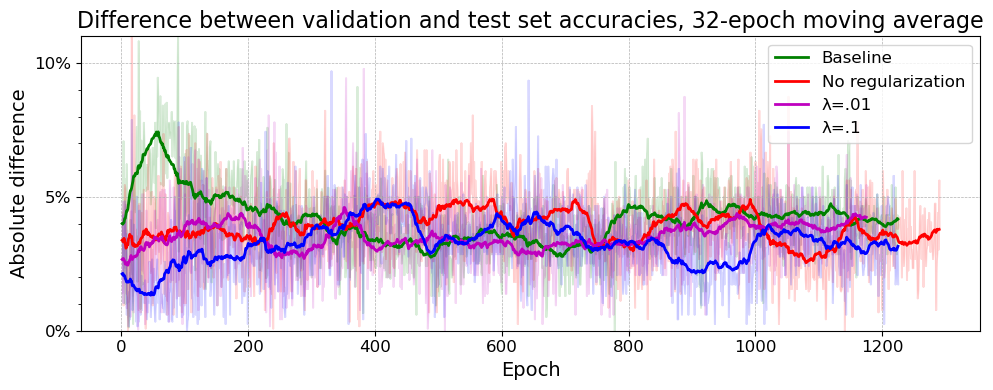

In [7]:
# 1.
baseline_val_acc = np.abs(np.array(baseline_log['val_accuracy']) - np.array(baseline_log['test_accuracy']))

# 2.
tau_per_neuron_val_acc = np.abs(np.array(tau_per_neuron_log['val_accuracy']) - np.array(tau_per_neuron_log['test_accuracy']))

# 3.
tau_per_neuron_regularization1_val_acc = np.abs(np.array(tau_per_neuron_regularization1_log['val_accuracy']) - np.array(tau_per_neuron_regularization1_log['test_accuracy']))

# 4.
tau_per_neuron_regularization2_val_acc = np.abs(np.array(tau_per_neuron_regularization2_log['val_accuracy']) - np.array(tau_per_neuron_regularization2_log['test_accuracy']))

labels = ['Baseline', 'No regularization', 'λ=.01', 'λ=.1']
accuracy_values = [baseline_val_acc, tau_per_neuron_val_acc, tau_per_neuron_regularization1_val_acc, tau_per_neuron_regularization2_val_acc]
colors = ['g', 'r', 'm', 'b']
window_size = 32
plt.figure(figsize=(10, 4))

def moving_average(values, window):
    return np.convolve(values, np.ones(window)/window, mode='valid')

def moving_range(values, window):
    min_vals = np.array([np.min(values[i:i+window]) for i in range(len(values) - window + 1)])
    max_vals = np.array([np.max(values[i:i+window]) for i in range(len(values) - window + 1)])
    return min_vals, max_vals

for i in range(len(labels)):
    acc_values = accuracy_values[i]
    ma_values = moving_average(acc_values, window_size)
    min_vals, max_vals = moving_range(acc_values, window_size)
    
    epochs = np.arange(1, 1 + len(ma_values))
    
    plt.plot(epochs, ma_values, color=colors[i], label=f'{labels[i]}', linewidth=2)
    # plt.fill_between(epochs, min_vals, max_vals, color=colors[i], alpha=0.1)
    plt.fill_between(epochs, [acc_values[i] for i in range(len(acc_values)-window_size+1)], [acc_values[i+1] for i in range(len(acc_values)-window_size+1)], color=colors[i], alpha=fill_alpha)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Absolute difference', fontsize=14)
plt.title(f'Difference between validation and test set accuracies, {window_size}-epoch moving average', fontsize=16)
plt.legend(title="", fontsize=12, title_fontsize='13')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0.0, 0.11) 
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
plt.xticks(fontsize=12)
yticks_major = np.arange(0.0, 0.11, 0.05)
yticks_minor = np.arange(0.0, 0.11, 0.01)
plt.yticks(yticks_major, [f'{int(round(y * 100))}%' for y in yticks_major], fontsize=12)
plt.gca().set_yticks(yticks_minor, minor=True)

plt.tight_layout()
plt.savefig('val_test_diff.png', dpi=400)
plt.show()

### Evolution of the membrane time constant parameters in each of the PLIF neuron layers

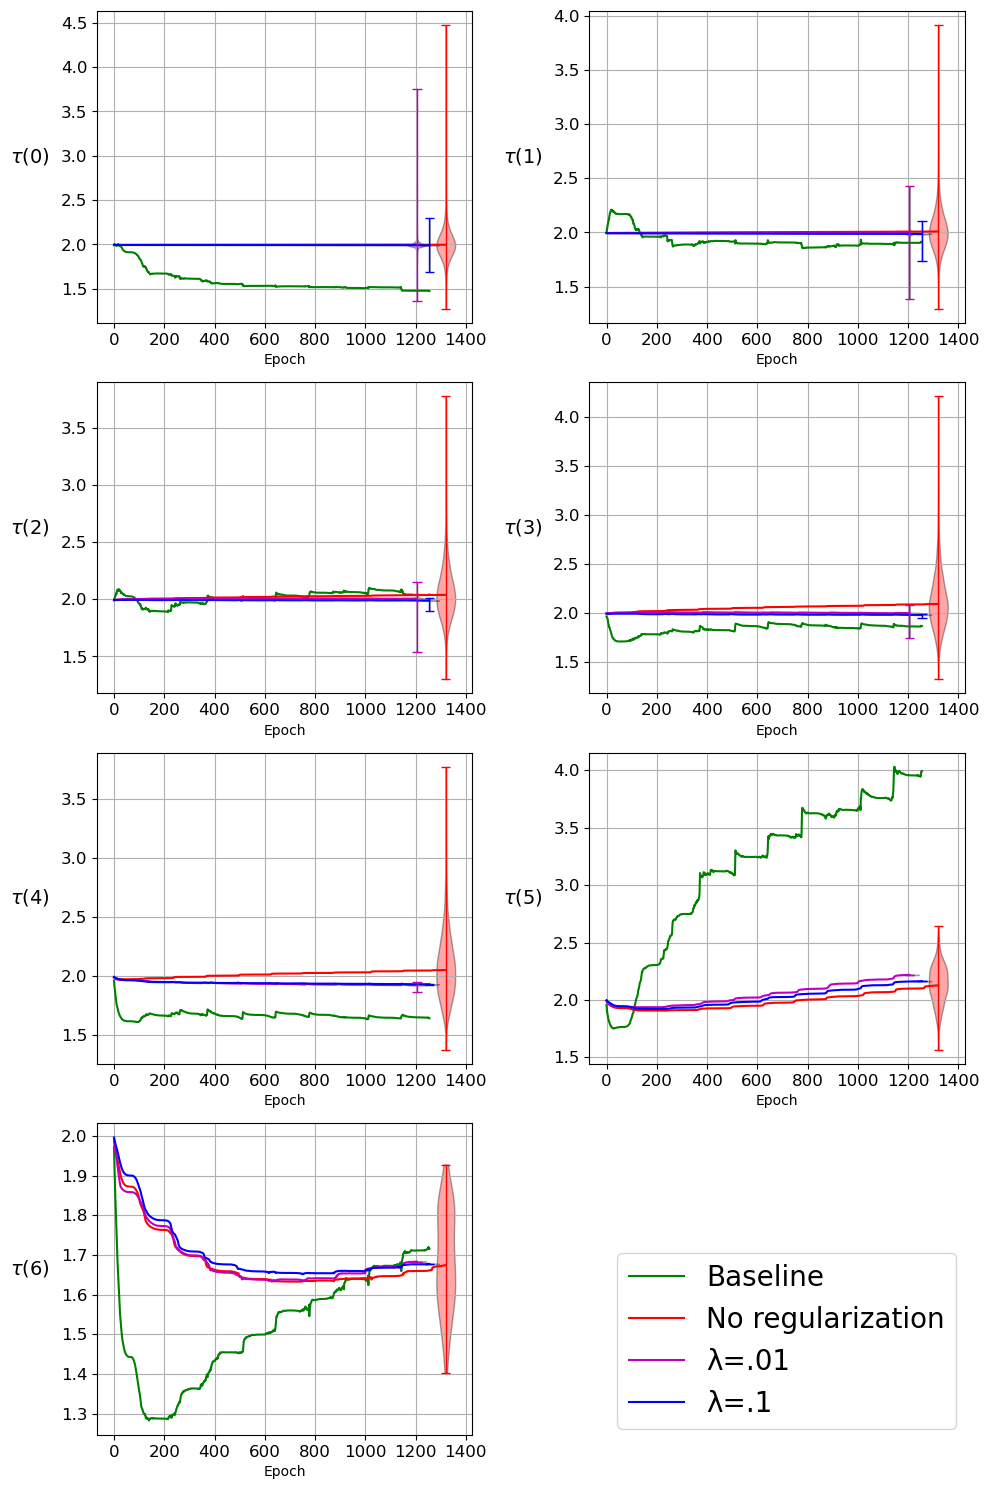

In [8]:
def get_tau_mean_from_weights(log):
    tau_mean = {}
    for key in log.keys():
        if key[0] != 'w':
            continue
        tau_mean[key] = (1 / torch.tensor(log[key]).sigmoid()).tolist()
    return tau_mean

# 1.
baseline_w_means = get_tau_mean_from_weights(baseline_log)

# 2.
tau_per_neuron_w_means = get_tau_mean_from_weights(tau_per_neuron_log)

# 3.
tau_per_neuron_regularization1_w_means = get_tau_mean_from_weights(tau_per_neuron_regularization1_log)

# 4.
tau_per_neuron_regularization2_w_means = get_tau_mean_from_weights(tau_per_neuron_regularization2_log)

labels = ['Baseline', 'No regularization', 'λ=.01', 'λ=.1']
weight_keys = list([k for k in tau_per_neuron_w_means.keys() if len(k) == 2])
colors = ['g', 'r', 'm', 'b']

# subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
# fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

# Evolution of the membrane time constant in each of the layers
for i, key in enumerate(weight_keys):
    ax = axes[i]
    ax.plot(baseline_w_means[key], color=colors[0], label=labels[0])
    ax.plot(tau_per_neuron_w_means[key], color=colors[1], label=labels[1])
    ax.plot(tau_per_neuron_regularization1_w_means[key], color=colors[2], label=labels[2])
    ax.plot(tau_per_neuron_regularization2_w_means[key], color=colors[3], label=labels[3])

    # Prepare the parameters of the final model instance to be displayed as a distribution using violin plots 
    data = [
        torch.flatten(tau_per_neuron_weights_final_dist[i]).numpy(),
        torch.flatten(tau_per_neuron_regularization1_weights_final_dist[i]).numpy(),
        torch.flatten(tau_per_neuron_regularization2_weights_final_dist[i]).numpy()
    ]

    positions = [
        len(tau_per_neuron_w_means[key]) - 1,
        len(tau_per_neuron_regularization1_w_means[key]) - 1,
        len(tau_per_neuron_regularization2_w_means[key]) - 1
    ]

    parts = ax.violinplot(data, positions=positions, widths=75, showmeans=False, showmedians=False, showextrema=True)

    # Customize violin plots
    for pc, color in zip(parts['bodies'], colors[1:]):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.35)
    
    for pc, color in zip(['cbars', 'cmins', 'cmaxes'], [colors[1:]] * 3):
        parts[pc].set_edgecolor(color)
        parts[pc].set_linewidth(1)

    # # Sanity check - visualize all points using a scatter plot with single x coordinate
    # for pos, dist, color in zip(positions, data, colors[1:]):
    #     ax.scatter([pos]*len(dist), dist, facecolor='none', edgecolor=color, alpha=0.2, marker='o', s=10, linewidth=0.5)

    ax.set_title('')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(rf'$\tau({i})$', rotation=0, labelpad=8, ha='right', fontsize=14)
    ax.grid(True)

# Remove the empty subplot - space used for the legend
for j in range(len(weight_keys), len(axes)):
    axes[j].axis('off')

for ax in axes.flat:
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=12)
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=12)

fig.legend(labels, bbox_to_anchor=(0.975, 0.17), ncol=1, fontsize=20)
# fig.legend(labels, bbox_to_anchor=(0.975, 0.32), ncol=1, fontsize=20)

plt.tight_layout()
plt.savefig('tau_parameters_mean_with_dist.png', dpi=200)
plt.show()

### Test accuracy of the models that perform the best on the validation dataset

In [9]:
baseline_best_test_acc = np.max(baseline_log['test_accuracy'])
tau_per_neuron_best_test_acc = np.max(tau_per_neuron_log['test_accuracy'])
tau_per_neuron_regularization1_best_test_acc =  np.max(tau_per_neuron_regularization1_log['test_accuracy'])
tau_per_neuron_regularization2_best_test_acc = np.max(tau_per_neuron_regularization2_log['test_accuracy'])

print(f"baseline: {baseline_best_test_acc}, num_epochs={len(baseline_log['test_accuracy'])}, max_test_epoch={np.argmax(baseline_log['test_accuracy'])}")
print(f"no regularization: {tau_per_neuron_best_test_acc}, num_epochs={len(tau_per_neuron_log['test_accuracy'])}, max_test_epoch={np.argmax(tau_per_neuron_log['test_accuracy'])}")
print(f"lambda=.01: {tau_per_neuron_regularization1_best_test_acc}, num_epochs={len(tau_per_neuron_regularization1_log['test_accuracy'])}, max_test_epoch={np.argmax(tau_per_neuron_regularization1_log['test_accuracy'])}")
print(f"lambda=.1: {tau_per_neuron_regularization2_best_test_acc}, num_epochs={len(tau_per_neuron_regularization2_log['test_accuracy'])}, max_test_epoch={np.argmax(tau_per_neuron_regularization2_log['test_accuracy'])}")

baseline: 0.9548611111111112, num_epochs=1256, max_test_epoch=339
no regularization: 0.9513888888888888, num_epochs=1321, max_test_epoch=150
lambda=.01: 0.9583333333333334, num_epochs=1206, max_test_epoch=526
lambda=.1: 0.9618055555555556, num_epochs=1256, max_test_epoch=557


In [10]:
baseline_best_val_acc = np.max(baseline_log['val_accuracy'])
tau_per_neuron_best_val_acc = np.max(tau_per_neuron_log['val_accuracy'])
tau_per_neuron_regularization1_best_val_acc =  np.max(tau_per_neuron_regularization1_log['val_accuracy'])
tau_per_neuron_regularization2_best_val_acc = np.max(tau_per_neuron_regularization2_log['val_accuracy'])

print(f"baseline: {baseline_best_val_acc}, num_epochs={len(baseline_log['val_accuracy'])}, max_val_epoch={np.argmax(baseline_log['val_accuracy'])}")
print(f"no regularization: {tau_per_neuron_best_val_acc}, num_epochs={len(tau_per_neuron_log['val_accuracy'])}, max_val_epoch={np.argmax(tau_per_neuron_log['val_accuracy'])}")
print(f"lambda=.01: {tau_per_neuron_regularization1_best_val_acc}, num_epochs={len(tau_per_neuron_regularization1_log['val_accuracy'])}, max_val_epoch={np.argmax(tau_per_neuron_regularization1_log['val_accuracy'])}")
print(f"lambda=.1: {tau_per_neuron_regularization2_best_val_acc}, num_epochs={len(tau_per_neuron_regularization2_log['val_accuracy'])}, max_val_epoch={np.argmax(tau_per_neuron_regularization2_log['val_accuracy'])}")

baseline: 1.0, num_epochs=1256, max_val_epoch=437
no regularization: 0.9921875, num_epochs=1321, max_val_epoch=152
lambda=.01: 0.9921875, num_epochs=1206, max_val_epoch=183
lambda=.1: 1.0, num_epochs=1256, max_val_epoch=432


### Loss evolution

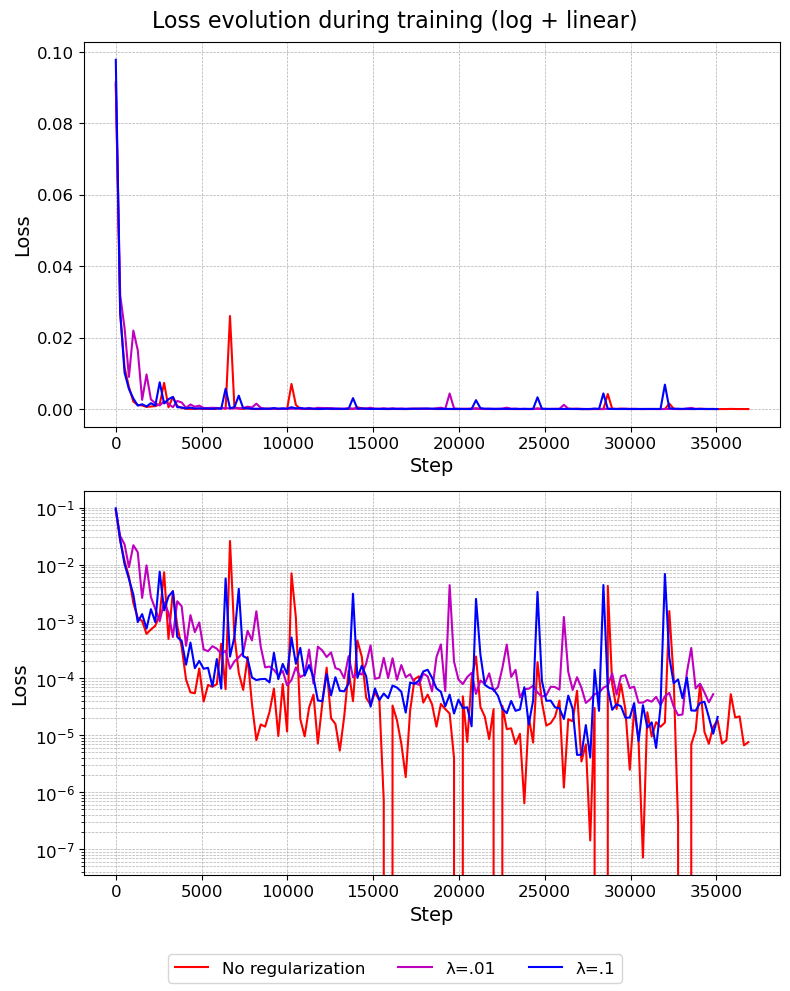

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_csv_loss(file_path):
    data = pd.read_csv(file_path)
    return data['Step'].values, data['Value'].values

# Load CSV files
tau_per_neuron_steps, tau_per_neuron_loss = load_csv_loss('../checkpoints/pt_NO_REG_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.1/logs/NO_REG_loss_data.csv')
tau_per_neuron_regularization1_steps, tau_per_neuron_regularization1_loss = load_csv_loss('../checkpoints/pt_REGULARIZATION_.01_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.1/logs/REGULARIZATION_.01_loss_data.csv')
tau_per_neuron_regularization2_steps, tau_per_neuron_regularization2_loss = load_csv_loss('../checkpoints/pt_REGULARIZATION_.1_val_0.15_DVS128Gesture_init_tau_2.0_tau_std_dev_0.1/logs/REGULARIZATION_.1_loss_data.csv')

loss_labels = ['No regularization', 'λ=.01', 'λ=.1']
loss_values = [tau_per_neuron_loss, tau_per_neuron_regularization1_loss, tau_per_neuron_regularization2_loss]
step_values = [tau_per_neuron_steps, tau_per_neuron_regularization1_steps, tau_per_neuron_regularization2_steps]
colors = ['r', 'm', 'b']

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

for i in range(len(loss_labels)):
    steps = step_values[i]
    loss = loss_values[i]
    
    ax1.plot(steps, loss, color=colors[i], label=f'{loss_labels[i]}', linewidth=1.5)
    ax2.plot(steps, loss, color=colors[i], label=f'{loss_labels[i]}', linewidth=1.5)

# Linear y-axis plot
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax1.set_title('Loss (linear)')

# Log y-axis plot
ax2.set_xlabel('Step', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax2.set_title('Loss (logarithmic)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12)

fig.suptitle(f'Loss evolution during training (log + linear)', fontsize=16)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('loss_evolution.png', dpi=300)
plt.show()
